In [40]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import P2_helpers as hlp

# 0. Preprocesse the raw data
### 0.1 Transform the data from the text file into a DataFrame
Simply by reading line by line the text file, changing each "paragraph" into an entry of the new DF.

In [50]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
original_df = df.copy()
df.sample(3)


,Source,Target,Vote,Results,Year,Date,Comment
65958,FlyingToaster,Protonk,1,1,2008,"06:51, 15 October 2008","'''Support''' - Great edits, no problems, acti..."
147038,Eluchil404,RyanGerbil10,1,1,2006,"11:52, 19 July 2006",'''Support''' per [[User:Tawker|Tawker]] and o...
159985,GHe,HighInBC,-1,-1,2006,"19:18, 27 May 2006",'''Oppose''' per reasons stated above. Like Ma...


### 0.2 Handle inconsistent data
 - Replace entirely space field or empyt filed by Numpy NaN values. Please note that the value None in the Comment is preferred.
 - Handle the inconsistent "Date" format.
 - Convert the type of Year into integer.

In [3]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN (the case for some Source, Date and Comment)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#handle NaN values in Comment for vectorization
df.Comment = df.Comment.replace(np.nan, None)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

# Convert Year to int
df['Year'] = df['Year'].astype(int)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
10800,Patar knight,Boing! said Zebedee,1,1,2011,2011-02-27 00:00:00,"'''Support''' Seen this user around the site, ..."
150145,Elkman,theProject,1,1,2006,2006-06-23 15:19:00,"'''Support''' per nom, record of contributions..."
119457,Siva1979,Mike6271,-1,-1,2007,2007-10-16 07:43:00,'''Oppose''' The lack of experience is major c...


### 0.3 Handle duplicate in the data
Please not that by manually checking the data we found that the number 6 discriminates perfectly between users with actual duplicates and users with only missing data or basic comments


In [4]:
# Select users with a significant number of duplicates (by manually checking the data we found that 6 discriminate perfectly between users with actual duplicates and users with only missing data or basic comments)
users_with_duplicates = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].groupby('Target').size() >= 6
users_with_duplicates = users_with_duplicates[users_with_duplicates].index
duplicates = df[df.Target.isin(users_with_duplicates) & df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull()].sort_values(by=['Target', 'Source', 'Date'])
#Remove the data of to_remove from df
df = df.drop(duplicates.index)


# Deal with duplicates that have different results 
perc_vote = (duplicates.groupby(['Target', 'Year']).Vote.value_counts(normalize=True) * 100).unstack(level='Vote')
perc_vote['Result'] = perc_vote.apply(lambda x: 1 if x['1'] >= 70 else -1, axis=1, result_type='reduce')
# Replace results in duplicates with results in perc_vote
duplicates['Results'] = duplicates.apply(lambda x: perc_vote.loc[(x['Target'], x['Year'])]['Result'].astype(int), axis=1)


# Deal with duplicates that have different years
correct_year = pd.DataFrame({'Year': duplicates.Date.dt.year, 'Target': duplicates.Target})
# Replace nan values in Year with most common year for each Target (some Dates are missing)
correct_year.Year = correct_year.groupby('Target').Year.transform(lambda x: x.fillna(x.mode()[0]))
# Replace years in duplicates with years in correct_year
duplicates = duplicates.drop(columns='Year').join(correct_year.Year)

# Drop the duplicate rows 
duplicates.drop_duplicates(keep='first', inplace=True)
# Add the duplicates to df
df = pd.concat([df, duplicates]).sort_index()


# Deal with duplicates that have different Vote
double_vote = df[df.duplicated(['Source', 'Target', 'Comment', 'Date'], keep=False) & df.Source.notnull() & df.Date.notnull() & (df.Vote == '0')]
# Drop the double_vote rows
df.drop(double_vote.index, inplace=True)

df.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment
195779,TUF-KAT,Solipsist,1,1,2004.0,NaT,None
130790,Deville,Circeus,1,1,2006.0,2006-03-29 13:26:00,"'''Support''', seems a very solid editor with ..."
115595,Coemgenus,Foundby,-1,-1,2007.0,2007-01-10 16:06:00,"'''Oppose''' Normally, I wouldn't even bother ..."


### 0.4 Saving the DataFrame 

In [47]:
#df.to_csv('wiki-RfA.csv')

# 1. Some global statistics and visualization
### 1.1 Basic description of the statistics

In [6]:
stats = df.describe(include='all')
stats.loc['percentage_nan'] = (1 - stats.loc['count'] / len(df)) * 100
stats

,Source,Target,Vote,Results,Year,Date,Comment
count,195647,197308,197308,197308,197308.000000,187998,190146
unique,10416,3497,3,4,NaN,NaN,163218
top,Siva1979,Everyking,1,1,NaN,NaN,'''Support'''
freq,1222,987,143951,122563,NaN,NaN,3446
mean,NaN,NaN,NaN,NaN,2007.493847,2008-01-25 16:26:19.400312320,NaN
min,NaN,NaN,NaN,NaN,2003.000000,2003-08-16 01:25:00,NaN
25%,NaN,NaN,NaN,NaN,2006.000000,2006-07-10 12:05:30,NaN
50%,NaN,NaN,NaN,NaN,2007.000000,2007-09-20 21:24:00,NaN
75%,NaN,NaN,NaN,NaN,2009.000000,2009-04-10 14:52:00,NaN
max,NaN,NaN,NaN,NaN,2013.000000,2013-06-05 19:50:00,NaN


### 1.2 Visualization

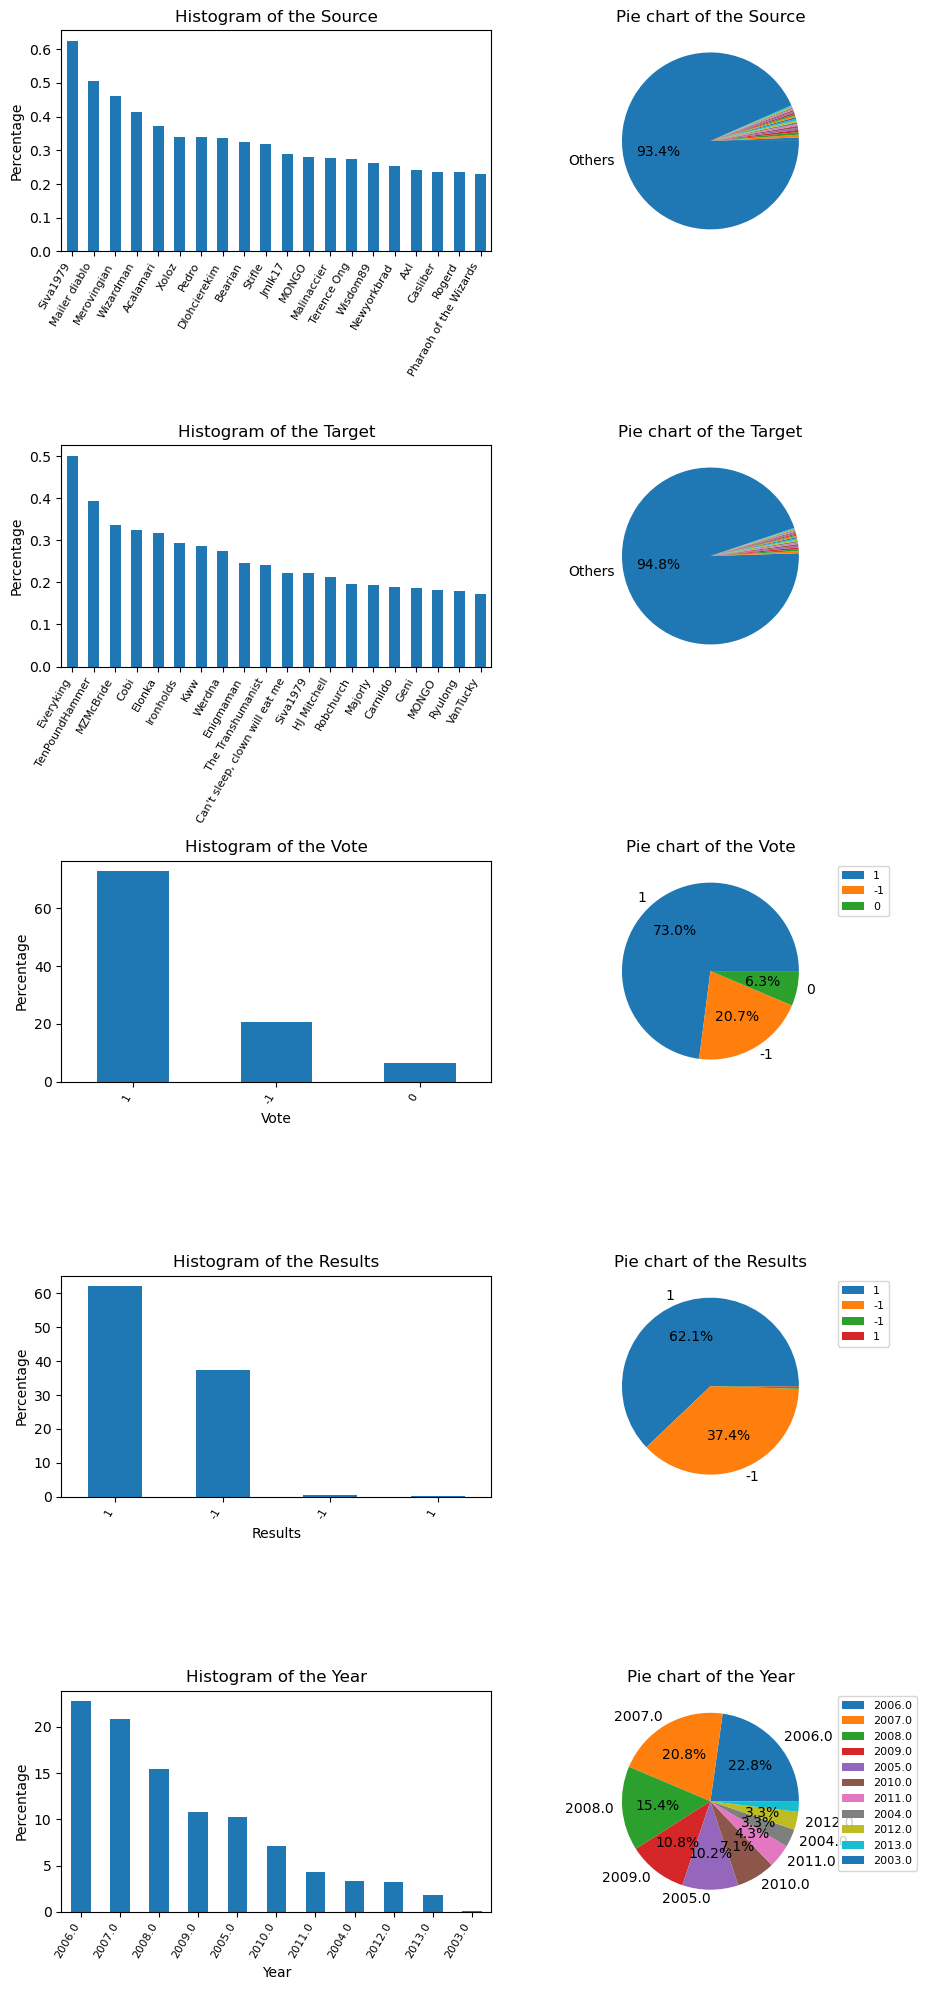

In [7]:
categorical_cols = ['Source', 'Target']
value_cols = ['Vote', 'Results', 'Year']
all_cols = categorical_cols + value_cols
n_top = 20
fig, axes = plt.subplots(len(all_cols), 2, figsize=(10,4*len(all_cols)))
for i, col in enumerate(all_cols):
    ax1 = axes[(2*i) // 2, (2*i) % 2]
    ax2 = axes[(2*i+1) // 2, (2*i+1) % 2]
    data = df[~df[col].isna()]
    if col in categorical_cols:
        top_n = pd.Series(data[col].value_counts().iloc[:n_top])
        others = pd.Series(data[col].value_counts().iloc[n_top:].sum(), index=['Others'])
        value_counts = pd.concat([top_n, others])
        
    elif col in value_cols:
        value_counts = data[col].value_counts()
    
    value_counts = 100*value_counts/np.sum(value_counts)
    labels = value_counts.index.to_list()

    # Count plot
    chart = value_counts[value_counts.index != 'Others'].plot(kind='bar', ax=ax1) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize = 8)
    ax1.set_title('Histogram of the ' + col)
    ax1.set_ylabel('Percentage')
    
    # Pie chart
    wedges, texts, autotexts = ax2.pie(value_counts, labels = labels, autopct='%1.1f%%')
    threshold = 2
    for label, pct_label in zip(texts, autotexts):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')
    
    #if too much labels, don't show legend
    if len(labels) < 12:
        ax2.legend(bbox_to_anchor=(1.05, 1), fontsize = 8)
    ax2.set_title('Pie chart of the ' + col)

fig.tight_layout()    
plt.show()

# 2. Time series computation and visualization of the votes and election rounds
### 2.1 Create and describe the time series 
The voting_time series will give the time in minutes at which each vote was cast with respect to the first vote recorded for the same target. We will consider the first vote as the opening time of the polls. Thus for each target we will have a voting time of 0. We print the basic statistic of the time serie.

In [8]:
voting_time = (df.groupby('Target').Date.apply(lambda x: x - x.min()).dt.total_seconds()/3600).rename('Voting_time')

# add voting time to df dataframe, merge on index
df_timeserie = df.join(voting_time.droplevel(0))

# Convert Vote, Results and Year to int
df_timeserie['Vote'] = df_timeserie['Vote'].astype(int)
df_timeserie['Results'] = df_timeserie['Results'].astype(int)
df_timeserie['Year'] = df_timeserie['Year'].astype(int)

# Plot basic statistics
df_timeserie['Voting_time'].describe().round(2)

count    187998.00
mean       1924.74
std        5943.52
min           0.00
25%          10.50
50%          46.80
75%         157.97
max       72598.02
Name: Voting_time, dtype: float64

### 2.2 Missing values

In [9]:
# Targets where all voting times are NaN
nan_target = set(df_timeserie.Target.unique()) - set(df_timeserie[~df_timeserie['Voting_time'].isna()].Target.unique())
print('Number of target without time data:', len(nan_target), ', corresponding to', round(len(nan_target)/len(df_timeserie.Target.unique())*100, 2), '% of all targets')
print('Target without time data:', nan_target)

# Amount of NaN values in the voting time column
print('Number of NaN values in the voting time column:', df_timeserie['Voting_time'].isna().sum(), ', corresponding to', round(df_timeserie['Voting_time'].isna().sum()/len(df_timeserie)*100, 2), '% of all values')

Number of target without time data: 29 , corresponding to 0.83 % of all targets
Target without time data: {'Mrmewe', 'CYD', 'Schneelocke', 'Talrias', 'Patrick', 'Mintguy', 'Lionelisbest', 'Vsmith', 'Dori', 'Tompagenet', 'Feco', 'Cyan', 'Olivier', 'Stevertigo', 'Jdforrester', 'Chadloder', 'Fantasy', 'RickK', 'Sarge Baldy', 'wavelab1', 'Craigy144', 'Bishonen', 'Delirium', 'Noel', 'J.J.', 'Zanimum', 'Woohookitty', 'Starblind', 'Meelar'}
Number of NaN values in the voting time column: 9310 , corresponding to 4.72 % of all values


Removing NaN values 

In [10]:
df_timeserie = df_timeserie[~df_timeserie['Voting_time'].isna()]

### 2.3 Analysis : Distribution of the voting time
#### 2.3.1 Histograms
We first plot the histogram and to be able to see something on the plot we need to use a log-axis for the votinf values. In order to be able to use it we remove the single vote that occures at time 0 for each election.

Plot histogram of voting time without log axis for voting time axis


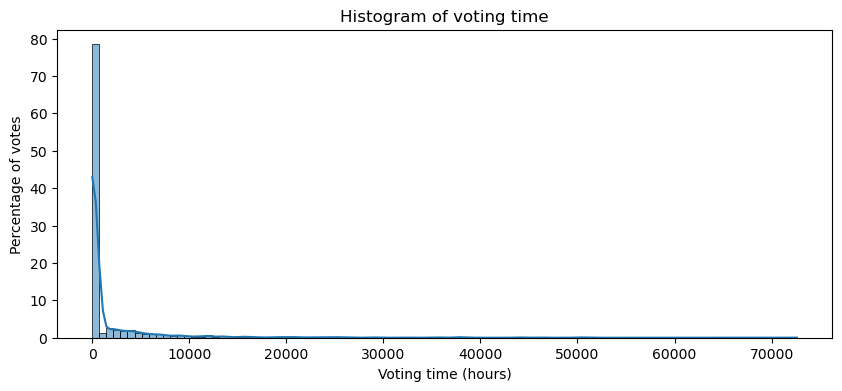

In [11]:
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_timeserie, x='Voting_time', kde=True, ax=ax, bins=100, stat='percent')
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

 Plot histogram of voting time with log axis for voting time axis


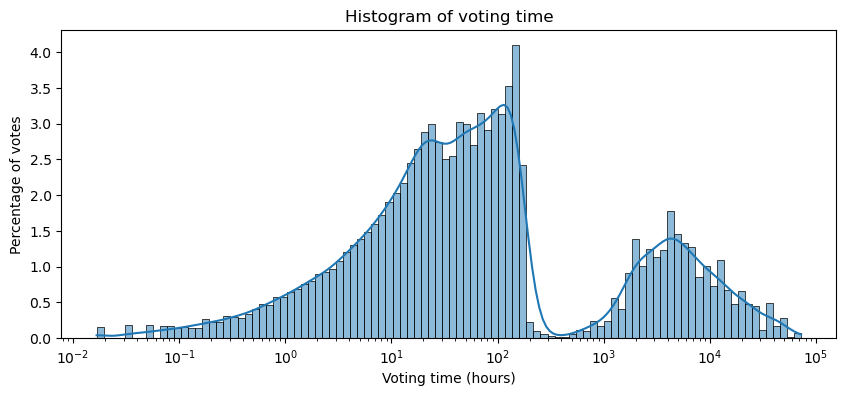

In [12]:
# Remove the vote at time 0 minute, to plot the histogram of voting time
df_plot = df_timeserie[df_timeserie.Voting_time != 0]

fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time',kde=True, ax=ax, bins=100, stat='percent', log_scale=(True, False))
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

#### 2.3.2 Plot the density function

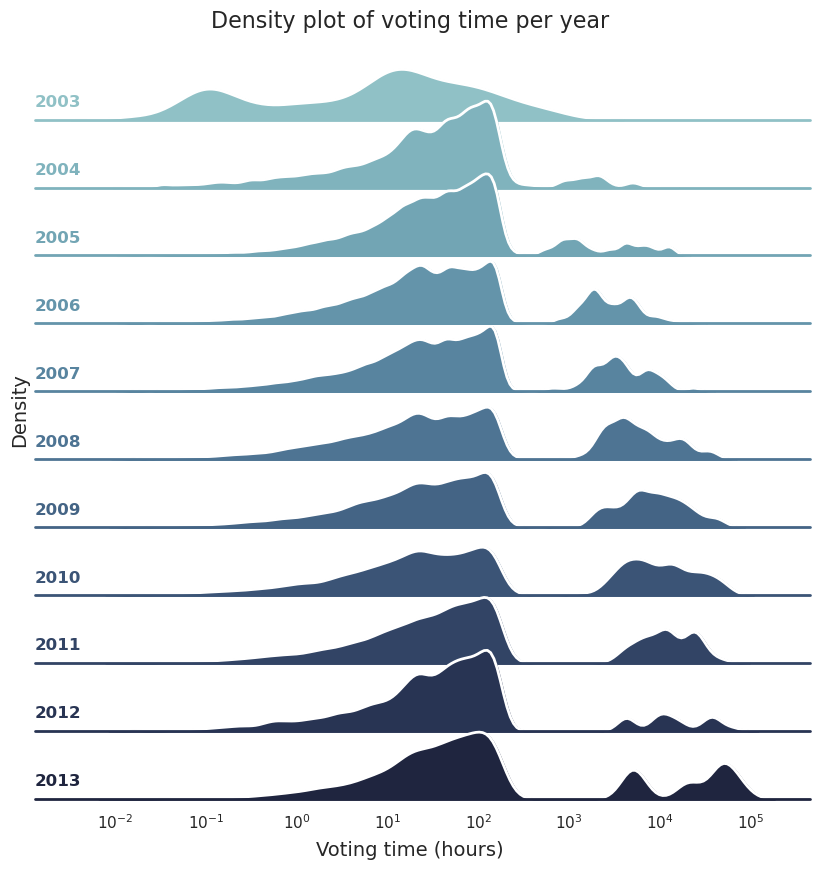

In [13]:
# Ignore warnings for the following plot - change in layout
import warnings 
warnings.filterwarnings('ignore')

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(11, rot=-.25, light=.7)
g = sns.FacetGrid(df_plot, row='Year', hue='Year', aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, 'Voting_time', bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5, log_scale=(True, False))
g.map(sns.kdeplot, 'Voting_time', clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
      ax = plt.gca()
      ax.text(0, .2, label, fontweight="bold", color=color,
                  ha="left", va="center", transform=ax.transAxes)

g.map(label, 'Voting_time')

# Set figure properties
#g.fig.set_tight_layout(True)
g.fig.subplots_adjust(hspace=-.25)
g.fig.set_figwidth(10)
g.fig.set_figheight(10)
g.fig.suptitle('Density plot of voting time per year', fontsize=16, y=0.9)
g.fig.supylabel('Density', fontsize=14, x=0.1)
g.fig.supxlabel('Voting time (hours)', fontsize=14, y=0.05)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='', xlabel='')
g.despine(bottom=True, left=True)

plt.show()
sns.set_theme()

We can notice at the first glance that in 2003 the voting time distribution was quite different from the other years. Indeed, the voting times were much more spread out and shifted to the left. This is probably due to the fact that at the creation of election system, the rules were not yet well established so the behaviour of the voters was not very consistent. 

#### 2.3.3 Dealing with year 2003
We will start by checking if the 2003 data represents a significant part of the data. 

In [14]:
proportion_2003 = df[df['Year'] == 2003].shape[0] / df.shape[0]
print(f'Proportion of 2003 data: {proportion_2003:.2%}')

Proportion of 2003 data: 0.10%


Knowing that the amount of data for 2003 represents only 0.1% of the total data, we can consider that these data are negligible and we can remove them from the dataset. 

In [15]:
df = df[df['Year'] != 2003]
#df.to_csv('wiki-RfA.csv')

df_timeserie = df_timeserie[df_timeserie['Year'] != 2003]
# Update the voting time of the df_timeserie dataframe
voting_time = (df_timeserie.groupby('Target').Date.apply(lambda x: x - x.min()).dt.total_seconds()/3600).rename('Voting_time')
df_timeserie = df_timeserie.drop(columns=['Voting_time']).join(voting_time.droplevel(0))

df_plot = df_timeserie[df_timeserie.Voting_time != 0]

#### 2.3.4 Time Interval between votes

The bimodal distribution we get when plotting on a log scale (2.3.2) was unexpected, thus we can look at the disribution of time intervals between votes to find an explanation to this phenomenon.

Frist we try to seperate votes into rounds using a manually craft waiting time between to votes to decide cut between two rounds. 

///
### A check
We choose the value of 72 hours, in other words 3 days. 
///

In [16]:
# Separate the vote for a candidate by elections rounds
votes_gap = df_timeserie.groupby('Target').Voting_time.apply(lambda x: x.sort_values().diff())
votes_gap.describe()

count    184438.000000
mean         20.277718
std         515.317045
min           0.000000
25%           0.216667
50%           0.716667
75%           2.233333
max       72247.600000
Name: Voting_time, dtype: float64

Plots histogram of "voting gap" - 

ValueError: autodetected range of [-inf, 4.858823424797878] is not finite

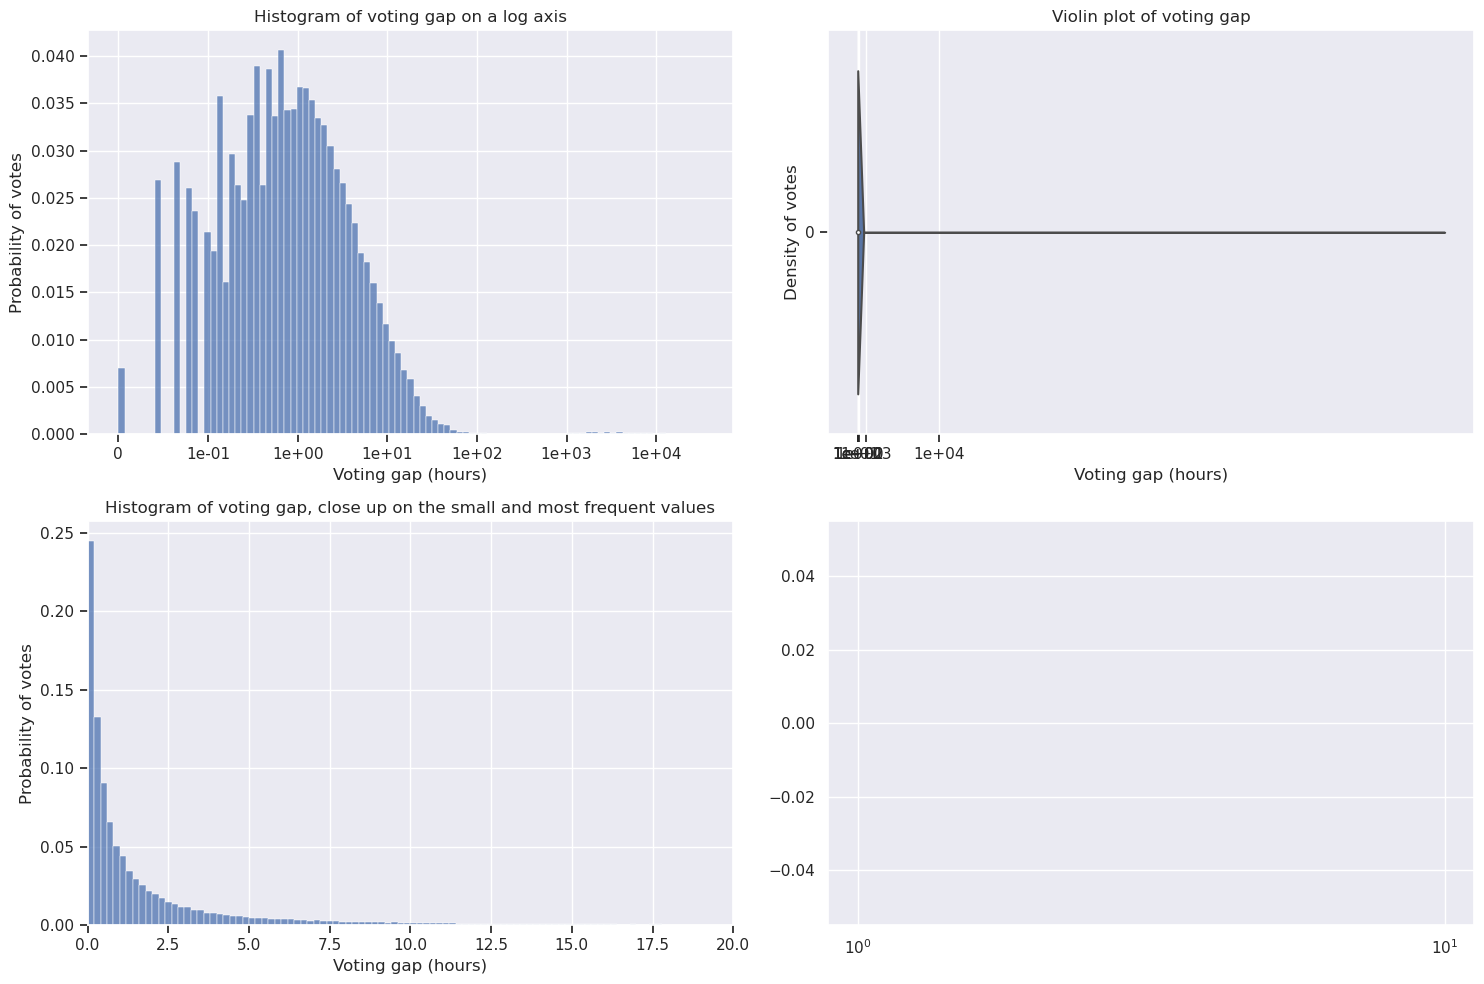

In [17]:
fig, ax = plt.subplots(2,2, figsize=(15,10), tight_layout=True)

log_shift = 0.01
votes_gap_plot = votes_gap.dropna() + log_shift

sns.histplot(data=votes_gap_plot, ax=ax[0,0], stat='probability', bins=100, log_scale=(True, False))
ax[0,0].set_title('Histogram of voting gap on a log axis')
ax[0,0].set_xlabel('Voting gap (hours)')
ax[0,0].set_ylabel('Probability of votes')
ax[0,0].tick_params(bottom=True, left=True)
ax[0,0].set_xlim(0, np.max(votes_gap))
ticks = np.power(10, np.arange(np.log10(log_shift), np.ceil(np.log10(np.max(votes_gap_plot))), 1))
labels = [f'{tick:.0e}' for tick in ticks]
labels[0] = '0'
ax[0,0].set_xticks(ticks, labels=labels)

# Violin plot of voting gap
sns.violinplot(data=votes_gap_plot, ax=ax[0,1], orient='h', bw=0.2, cut=0, log_scale=(True, False), split=True, inner_kws=dict(box_width=10, whis_width=2, color="lightsteelblue"))
ax[0,1].set_title('Violin plot of voting gap')
ax[0,1].set_xlabel('Voting gap (hours)')
ax[0,1].set_ylabel('Density of votes')
ax[0,1].tick_params(bottom=True, left=True)
ax[0,1].set_xticks(ticks, labels=labels)

sns.histplot(data=votes_gap, ax=ax[1,0], stat='probability', bins=100, binrange=(0,20))
ax[1,0].set_title('Histogram of voting gap, close up on the small and most frequent values')
ax[1,0].set_xlabel('Voting gap (hours)')
ax[1,0].set_ylabel('Probability of votes')
ax[1,0].set_xlim(0, 20)
ax[1,0].tick_params(bottom=True, left=True)


sns.histplot(data=votes_gap, ax=ax[1,1], stat='probability', bins=100, log_scale=(True, False))
ax[1,1].set_title('Histogram of voting gap, close up on the extreme and rare values, logscale')
ax[1,1].set_xlabel('Voting gap (hours)')
ax[1,1].set_ylabel('Probability of votes')
ax[1,1].set_xlim(20, np.max(votes_gap))
ax[1,1].set_ylim(0, 0.01)
ax[1,1].set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000], labels=['20', '50', '100', '200', '500', '1000', '2000', '5000', '10000', '20000', '50000']) 
ax[1,1].tick_params(bottom=True, left=True)

plt.show()

In [18]:
print(f'Extract the voting gap corresponding to the 99% quantile: {votes_gap.quantile(0.99):.2f} hours')

Extract the voting gap corresponding to the 99% quantile: 26.90 hours


We can see that the distribution of the time interval between votes almost follows an exponential distribution (which is what we would expect for this type of data). However, we can see that there is an additional very small peak between 1000 and 20000 hours, which reveals the presence of multiple batches/aggregate of votes separated by a long period of time. 

We interpret this as different rounds of elections. Indeed, some target are not elected at the first try and they run for admin again after a certain period of time. We now want to separate the data into different rounds of elections for each target.

#### 2.3.5 Separate data into rounds of elections


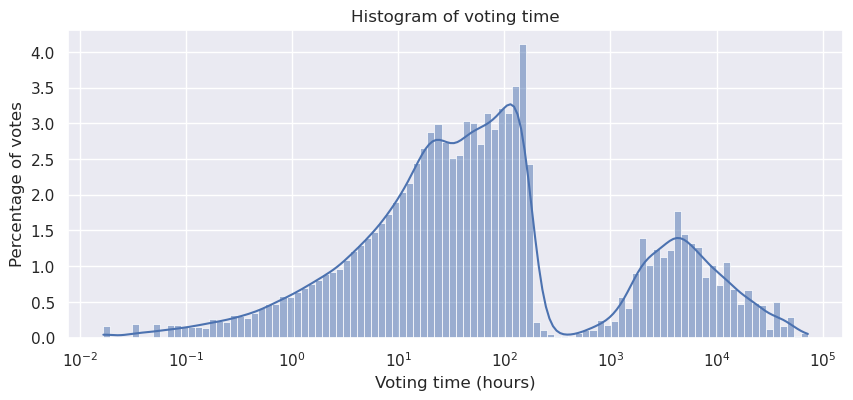

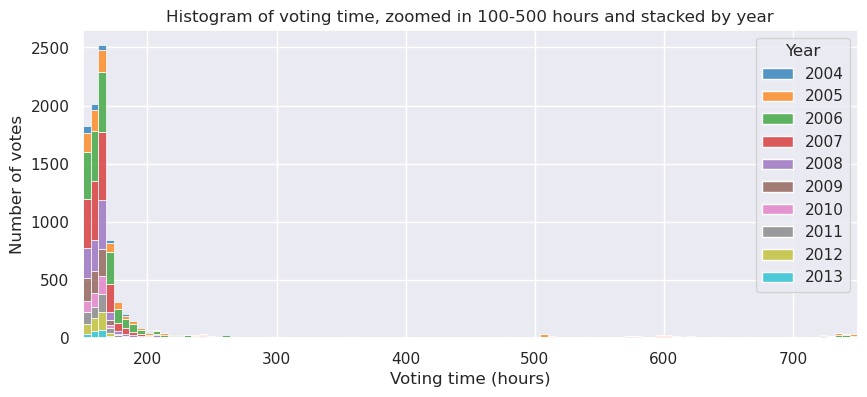

After this threshold in hours, we consider that the incoming votes are part of a new election: 391.11 hours
Percentage of votes happening at this threshold: 0.041%


In [19]:
fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time', kde=True, ax=ax, bins=100, stat='percent', log_scale=(True, False))
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

# Close up the voting time to 100-500 hours
fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=df_plot, x='Voting_time', ax=ax, bins=100, stat='count', log_scale=(False, False), binrange=(150, 750), hue='Year', palette='tab10', multiple='stack')
ax.set_title('Histogram of voting time, zoomed in 100-500 hours and stacked by year')
ax.set_xlabel('Voting time (hours)')
ax.set_ylabel('Number of votes')
ax.set_xlim(150, 750)
plt.show()

# Fin the local minima
kde = kde.get_lines()[0].get_data()
deriv_kde_sign = np.sign(np.diff(kde[1]))
local_mins = kde[0][np.append((np.roll(deriv_kde_sign, 1) - deriv_kde_sign) != 0, False)]
y_mins = kde[1][np.append((np.roll(deriv_kde_sign, 1) - deriv_kde_sign) != 0, False)]

# only keep the minima with a y value < 0.1 and a x value is between 10 and 1e4
round_threshold = local_mins[(y_mins < 0.1) & (local_mins > 10) & (local_mins < 1e3)][0]
percent_at_threshold = y_mins[(y_mins < 0.1) & (local_mins > 10) & (local_mins < 1e3)][0]

print(f'After this threshold in hours, we consider that the incoming votes are part of a new election: {round_threshold:.2f} hours')
print(f'Percentage of votes happening at this threshold: {percent_at_threshold:.2}%')

To separate the different rounds of elections we focus on the gap between the 2 peaks in the distribution of voting time. First, we can observe that there is a huge drop in the amount of votes at around 170h which is consistent with the information we found on the Wikipedia page about the election duration being approximately 7 days (noting that this period can be prolonged in some cases). 

To find the best threshold to separate the data, we extracted the kernel density estimation of the distribution of voting time and we computed its local minimum in the gap between the 2 peaks and the corresponding voting time. We found that the best threshold to separate the data is 391h. We can now separate the data into different rounds of elections for each target using this threshold.

In [20]:
rounds = (df_timeserie.groupby('Target').apply(lambda x: hlp.compute_rounds(x, round_threshold))).rename('Round')
df_timeserie = df_timeserie.join(rounds.droplevel(0))
df_timeserie.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Voting_time,Round
6248,And Adoil Descended,TommyBoy,1,1,2012,2012-11-12 02:14:00,'''Support''' Appears to be a solid candidate ...,3.033333,1
157710,Locke Cole,Djr xi,1,-1,2006,2006-02-19 02:10:00,'''Support''' —,73.416667,1
150761,Kusma,Turnstep,1,1,2006,2006-03-23 12:10:00,'''Support''',10.150000,1


#### 2.3.6 Updating the voting time with respect to election rounds

In [21]:
# Use the round number to compute the voting time in each round (i.e. the time between the current vote and the first vote of the round)
Voting_time_round = df_timeserie.groupby(['Target', 'Round']).Voting_time.apply(lambda x: x - x.min())
# Replace the column Voting_time by the voting time in each round
df_timeserie = df_timeserie.drop(columns='Voting_time').join(Voting_time_round.droplevel([0,1]))
df_plot = df_timeserie[df_timeserie.Voting_time != 0]
df_timeserie.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time
186525,David Gerard,Zscout370,1,1,2005,2005-08-05 06:08:00,None,1,26.166667
35320,Aditya,decltype,1,1,2009,2009-06-29 09:38:00,"'''Support''' Good AIV, CSD work. Would make a...",1,117.316667
7963,SarekOfVulcan,James1011R,-1,-1,2012,2012-03-22 19:02:00,"[[WP:NOTNOW]]. Sorry, James, but if you think ...",1,0.133333


Ploting the histogram of voting time

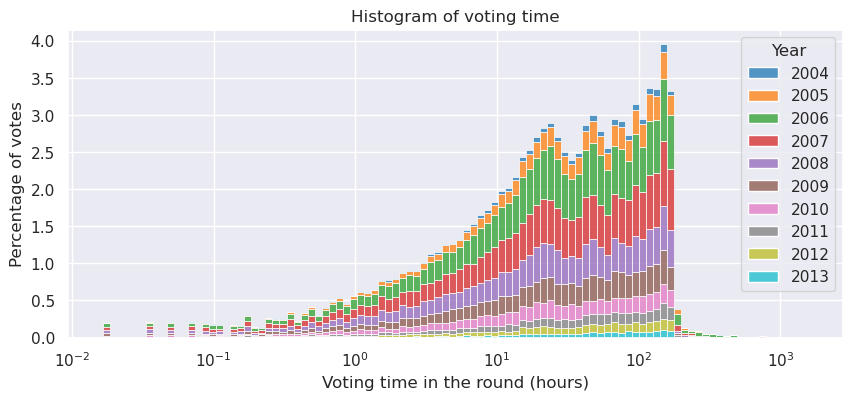

In [22]:
fig, ax = plt.subplots(figsize=(10,4))
kde = sns.histplot(data=df_plot, x='Voting_time', ax=ax, bins=100, stat='percent', log_scale=(True, False), hue='Year', palette='tab10', multiple='stack')
ax.set_title('Histogram of voting time')
ax.set_xlabel('Voting time in the round (hours)')
ax.set_ylabel('Percentage of votes')
plt.show()

In [23]:
#df_timeserie.to_csv('wiki-RfA_timeserie.csv')

### 2.4 Votes evolution through time - explication nécessaire @Emma
We now focus on the study of statistics from votes. We first compute the progressive mean of the votes (the votes themselves ?).
 

In [24]:
#saving previous work.
df_vote_evolution = df_timeserie.copy()

progressive_mean = df_vote_evolution.groupby(['Target', 'Round']).apply(lambda x: x.Vote.cumsum() / np.arange(1, len(x)+1)).rename('progressive_mean')

# Replace the column Vote by the progressive mean
df_vote_evolution = df_vote_evolution.join(progressive_mean.droplevel([0,1]))
df_vote_evolution.sample(3)

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time,progressive_mean
99234,SandyGeorgia,Marskell,1,1,2007,2007-02-18 01:26:00,'''Strong support'''; Marskell would be just t...,1,12.666667,1.0
106922,Z.E.R.O.,Soumyasch,1,1,2007,2007-04-04 05:22:00,'''Strong Support''': <small>I hope you will s...,1,118.783333,1.0
102518,Phoenix2,Pax:Vobiscum,1,1,2007,2007-06-03 01:04:00,"'''Support'''. Majorly, is it not hypocritical...",1,0.783333,1.0


Convert the voting time into time deltas.

In [25]:
df_vote_evolution.Voting_time = pd.to_timedelta(df_vote_evolution.Voting_time, unit='h')
df_vote_evolution.sort_values('Voting_time', inplace=True)
display(df_vote_evolution.sample(3))

,Source,Target,Vote,Results,Year,Date,Comment,Round,Voting_time,progressive_mean
132359,Ageo020,Deepujoseph,1,1,2006,2006-10-14 17:49:00,'''Support as co-nom''' Sorry couldn't vote ea...,1,0 days 12:19:59.999999998,1.0
71864,CrazyChemGuy,Ammar gerrard117,-1,-1,2008,2008-06-06 05:06:00,"'''Oppose''' ""None"" is not an okay answer for ...",1,0 days 00:12:00,-1.0
162323,Jedi6,laurenceandrews,-1,-1,2006,2006-04-12 15:28:00,'''Oppose''' short answers and doesn't seem to...,1,0 days 00:00:00,-1.0


In [26]:
rolling_avg = df_vote_evolution.groupby('Results').rolling('1h', on='Voting_time').progressive_mean.aggregate(['mean', 'std']).reset_index(level='Voting_time')
rolling_avg.Voting_time = rolling_avg.Voting_time.dt.total_seconds()/3600
display(rolling_avg.sample(3))

,Voting_time,mean,std
Results,,,
1,30.000000,0.985071,0.059357
-1,17.833333,0.522755,0.558541
1,144.316667,0.963332,0.104129


Plot the evolution of the progressive mean of the votes in each round given rolling average.

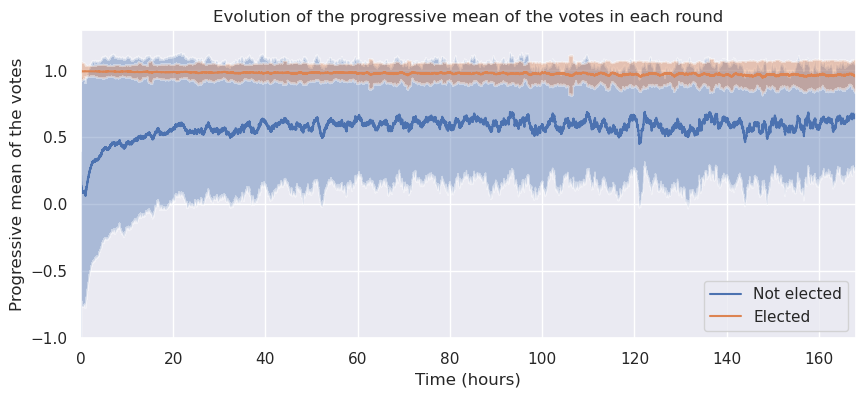

In [34]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rolling_avg.loc[-1].Voting_time, rolling_avg.loc[-1]['mean'], label='Not elected')
ax.fill_between(rolling_avg.loc[-1].Voting_time, rolling_avg.loc[-1]['mean']-rolling_avg.loc[-1]['std'], rolling_avg.loc[-1]['mean']+rolling_avg.loc[-1]['std'], alpha=0.4)
ax.plot(rolling_avg.loc[1].Voting_time, rolling_avg.loc[1]['mean'], label='Elected')
ax.fill_between(rolling_avg.loc[1].Voting_time, rolling_avg.loc[1]['mean']-rolling_avg.loc[1]['std'], rolling_avg.loc[1]['mean']+rolling_avg.loc[1]['std'], alpha=0.4)
ax.set_title('Evolution of the progressive mean of the votes in each round')
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Progressive mean of the votes')
ax.set_xlim(0, 24*7)
ax.set_ylim(-1, 1.3)
ax.legend(loc='lower right')
plt.show()  

In [28]:
df_vote_evolution.groupby('Results')[['progressive_mean']].agg(['mean', 'std'])

progressive_mean          
                    mean       std
Results                           
-1              0.454460  0.636774
 1              0.982224  0.074236

# 3. Dive into on the Sources
### 3.1 Distribution of the source voting

In [29]:
df_source = df.copy(deep=True)
#Artifact from the merge of code but for this part we need to interpret the Vote as integer
df_source.Vote = df_source.Vote.astype(int)

First we get a glance at the proportion of distinct source by year in comparison with the total number of sources overall.

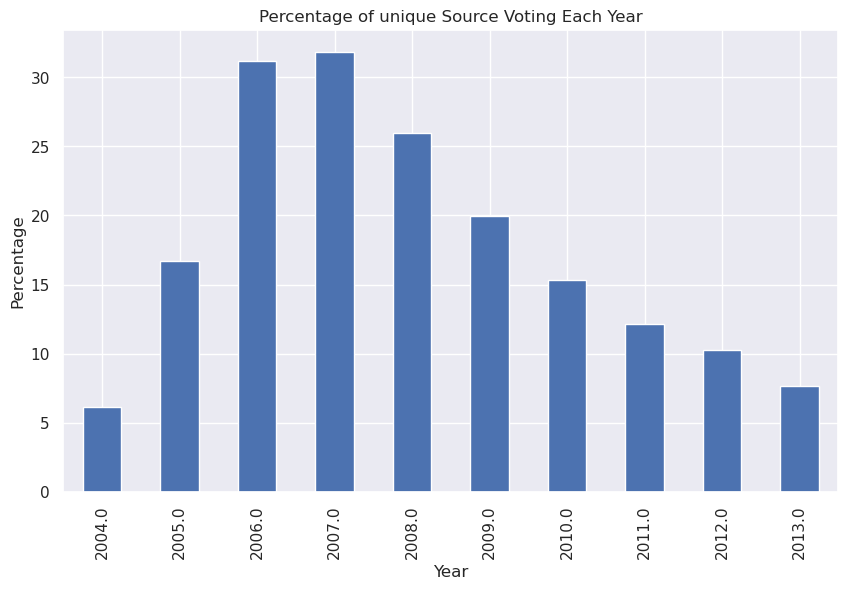

In [30]:
# Calculate the distribution of the source over the year
source_percentage = df_source.groupby('Year')['Source'].nunique() / len(df_source.Source.unique())*100

# Plotting
source_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage of unique Source Voting Each Year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

For each year we consider we take the average of the percentage of unique source that vote for a target. It gives us an indicator of the proportion of source participating in average. 

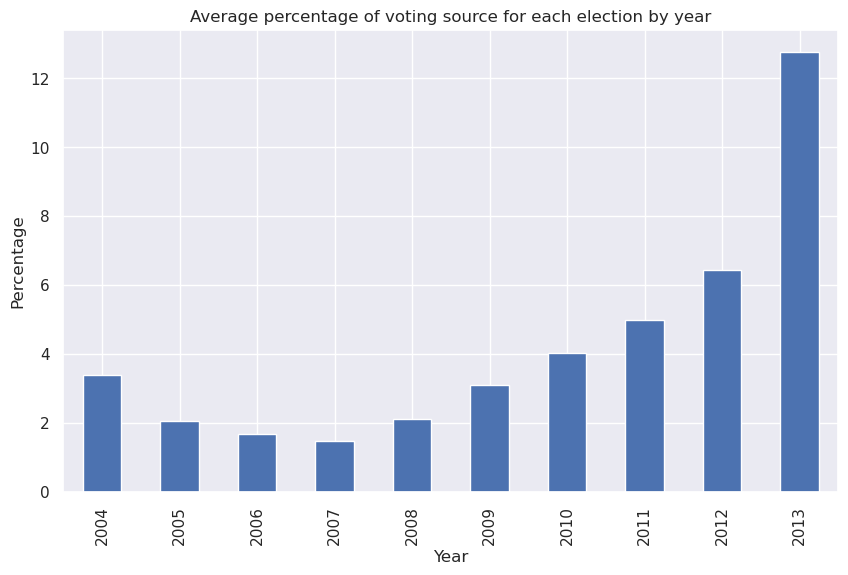

In [31]:
d={}
year_index = range(2004, 2014)
for i in year_index:
  df_sub = hlp.select_year(df_source, i)
  nb_source =  len(df_sub.Source.unique())
  percent_by_target = df_sub.groupby('Target')['Source'].nunique()/nb_source*100
  d.update({i:percent_by_target.mean()})

election_source_percentage = pd.Series(data=d, index=year_index)

election_source_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average percentage of voting source for each election by year')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.show()

To have a "baseline" for the distribution of all votes we plot the count of votes for each year.

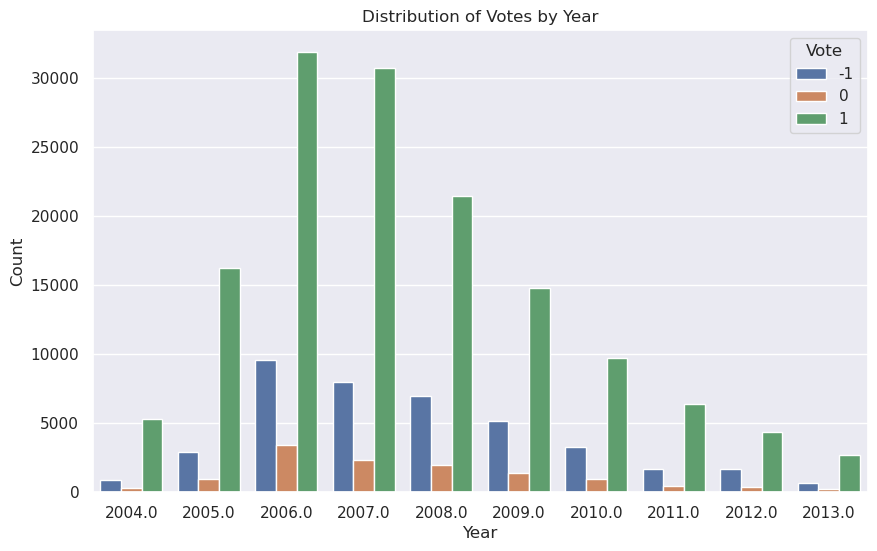

In [32]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Year', hue='Vote', data=df_source)
plt.title('Distribution of Votes by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Vote', loc='upper right', labels=['-1', '0', '1'])
plt.show()

We can see that the trends of the proportion of different sources voting for at least one election by year and the average proportion of different soucres voting for specific vote is inversed.

On the other hand we can see that the proportion of different sources voting for at least one election is follwing the number of votes which seems fair. 

# 4. Community Extraction of Sources based on similar vote for Targets
We will use Louvain and Leiden algorithm, the second one beeing an improvement of the first: https://www.nature.com/articles/s41598-019-41695-z.

More on the implementation here: https://readthedocs.org/projects/leidenalg/downloads/pdf/latest/

In [37]:
import igraph as ig 
import leidenalg as la

### 4.1 Louvain Algorithm

In [60]:
#Create a new DataFrame to hold the community data
columns = ['Year', 'Vote', 'Total nbr of community', 'Size of each community', 'Community members']
df_community=pd.DataFrame(columns=columns)

wiki_RfA_df = pd.read_csv('wiki-RfA.csv', index_col=0, parse_dates=['Date'])

#Extracts the community of a given year and vote
years=wiki_RfA_df['Year'].unique()
for n, year in enumerate(years):
    G_community_pos = hlp.extract_community_louvain(wiki_RfA_df, year,1)
    size_communities_pos = hlp.compute_com_size(G_community_pos)
    df_community.loc[3*n] = [year, 1, len(size_communities_pos), size_communities_pos, G_community_pos]
    
    G_community_neg = hlp.extract_community_louvain(wiki_RfA_df, year,-1)
    size_communities_neg = hlp.compute_com_size(G_community_neg)
    df_community.loc[3*n+1] = [year, -1, len(size_communities_neg), size_communities_neg, G_community_neg]
    
    G_community_neu = hlp.extract_community_louvain(wiki_RfA_df, year,0)
    size_communities_neu = hlp.compute_com_size(G_community_neu)
    df_community.loc[3*n+2] = [year, 0, len(size_communities_neu), size_communities_neu, G_community_neu]

df_community.sample(3)


,Year,Vote,Total nbr of community,Size of each community,Community members
10,2010.0,-1,13,"[2, 2, 129, 2, 26, 67, 115, 108, 63, 130, 26, ...","[{Arsenikk, Equazcion}, {Eustress, Marco Guzma..."
28,2005.0,-1,16,"[14, 78, 124, 98, 2, 2, 2, 45, 74, 2, 2, 30, 1...","[{Sansculotte, Crux, Elephantus, Avatar-en, Le..."
3,2012.0,1,9,"[155, 80, 141, 202, 86, 116, 73, 2, 93]","[{nan, Cyberpower678, Ohiostandard, TucsonDavi..."


Plots the number of community per year and type of vote

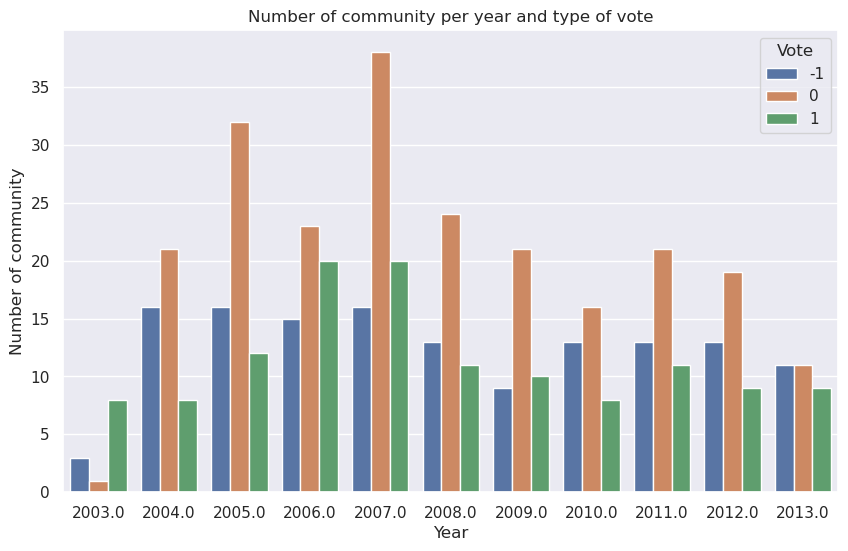

In [72]:
sns.barplot(data=df_community[['Year', 'Vote', 'Total nbr of community']], x='Year', y='Total nbr of community', hue='Vote')

sns.set(rc={'figure.figsize':(10, 6)})
plt.title('Number of community per year and type of vote')
plt.xlabel('Year')
plt.ylabel('Number of community')
plt.show()

# Todo 
see if we add from source_alex the count of vote for each year